<a href="https://colab.research.google.com/github/DulithMH/NASA-Campss/blob/main/NASA_Campss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import kagglehub
path = kagglehub.dataset_download("palbha/cmapss-jet-engine-simulated-data")

Using Colab cache for faster access to the 'cmapss-jet-engine-simulated-data' dataset.


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
import os

# List contents of the downloaded dataset directory
dataset_files = os.listdir(path)
print(f"Files in the dataset directory: {dataset_files}")

# Load 'train_FD001.txt' into a Pandas DataFrame
# Based on common practice for this dataset, files are space-separated and have no header.
train_df = pd.read_csv(os.path.join(path, 'train_FD001.txt'), sep=' ', header=None)

print(f"Shape of train_df: {train_df.shape}")
print("First 5 rows of train_df:")
print(train_df.head())

Files in the dataset directory: ['RUL_FD002.txt', 'test_FD003.txt', 'Damage Propagation Modeling.pdf', 'readme.txt', 'train_FD003.txt', 'test_FD004.txt', 'train_FD004.txt', 'test_FD002.txt', 'train_FD001.txt', 'train_FD002.txt', 'RUL_FD001.txt', 'RUL_FD004.txt', 'RUL_FD003.txt', 'test_FD001.txt']
Shape of train_df: (20631, 28)
First 5 rows of train_df:
   0   1       2       3      4       5       6        7        8      9   \
0   1   1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60  14.62   
1   1   2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14  14.62   
2   1   3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20  14.62   
3   1   4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87  14.62   
4   1   5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22  14.62   

   ...       18      19    20   21    22     23     24       25  26  27  
0  ...  8138.62  8.4195  0.03  392  2388  100.0  39.06  23.4190 NaN NaN  
1  ...  8131.49  8.4318  0.03  392

In [44]:
# Calculate standard deviation for each column
std_devs = train_df.std()

# Identify columns with standard deviation of 0
zero_std_cols = std_devs[std_devs == 0].index.tolist()

print(f"Columns with zero standard deviation (constant values): {zero_std_cols}")

# Drop these columns from the DataFrame
if zero_std_cols:
    train_df_cleaned = train_df.drop(columns=zero_std_cols)
    print(f"Dropped {len(zero_std_cols)} columns.")
    print(f"New shape of train_df: {train_df_cleaned.shape}")
else:
    train_df_cleaned = train_df.copy()
    print("No columns with zero standard deviation found.")

# Update train_df to the cleaned version
train_df = train_df_cleaned

Columns with zero standard deviation (constant values): [4, 22, 23]
Dropped 3 columns.
New shape of train_df: (20631, 25)


In [45]:
# Assuming column 0 is 'unit_number' and column 1 is 'cycle'
# Rename columns for clarity if needed, but for now, we'll use numerical indices.

# Calculate max cycle for each unit
max_cycles = train_df.groupby(0)[1].max().reset_index()
max_cycles.columns = ['unit_number', 'max_cycle']

# Merge max_cycles back to the original DataFrame
train_df = train_df.merge(max_cycles, left_on=0, right_on='unit_number', how='left')

# Calculate RUL
train_df['RUL'] = train_df['max_cycle'] - train_df[1]

# Drop the 'unit_number' and 'max_cycle' columns added during merge if they are redundant
# Keeping them for now to show the process, but can be dropped later if not needed.

# Print the first few rows with the new RUL column
print("First 5 rows of train_df with RUL:")
print(train_df.head())

# Display some descriptive statistics for RUL
print("\nDescriptive statistics for RUL:")
print(train_df['RUL'].describe())

First 5 rows of train_df with RUL:
   0  1       2       3       5       6        7        8      9     10  ...  \
0  1  1 -0.0007 -0.0004  518.67  641.82  1589.70  1400.60  14.62  21.61  ...   
1  1  2  0.0019 -0.0003  518.67  642.15  1591.82  1403.14  14.62  21.61  ...   
2  1  3 -0.0043  0.0003  518.67  642.35  1587.99  1404.20  14.62  21.61  ...   
3  1  4  0.0007  0.0000  518.67  642.35  1582.79  1401.87  14.62  21.61  ...   
4  1  5 -0.0019 -0.0002  518.67  642.37  1582.85  1406.22  14.62  21.61  ...   

       19    20   21     24       25  26  27  unit_number  max_cycle  RUL  
0  8.4195  0.03  392  39.06  23.4190 NaN NaN            1        192  191  
1  8.4318  0.03  392  39.00  23.4236 NaN NaN            1        192  190  
2  8.4178  0.03  390  38.95  23.3442 NaN NaN            1        192  189  
3  8.3682  0.03  392  38.88  23.3739 NaN NaN            1        192  188  
4  8.4294  0.03  393  38.90  23.4044 NaN NaN            1        192  187  

[5 rows x 28 columns]

Desc

he Windowing Function

In [46]:
import numpy as np

# 1. Define constants
SEQUENCE_LENGTH = 50
RISK_THRESHOLD = 30 # RUL <= 30 is considered "High Risk"

# 2. Select the features (sensors) you want to use
# Identify sensor columns by their numerical indices, excluding unit_number (0), cycle (1),
# and the two 'NaN' columns (26, 27) which are not sensor readings.
sensor_cols = [col for col in train_df.columns if isinstance(col, int) and col not in [0, 1, 26, 27]]

def create_sequences(data, seq_length, feature_cols):
    X = []
    y_reg = []   # For the score (Regression)
    y_class = [] # For the risk (Classification)

    for unit_id in data[0].unique(): # Assuming column 0 is unit_number
        unit_df = data[data[0] == unit_id]
        unit_values = unit_df[feature_cols].values
        unit_rul = unit_df['RUL'].values

        # We can only create a window if the engine has enough cycles
        if len(unit_df) >= seq_length:
            for i in range(len(unit_df) - seq_length + 1):
                # Extract the sensor window
                X.append(unit_values[i : i + seq_length])

                # The target is the RUL at the END of this window
                current_rul = unit_rul[i + seq_length - 1]
                y_reg.append(current_rul)

                # Create the Risk Label: 1 if RUL <= 30, else 0
                label = 1 if current_rul <= RISK_THRESHOLD else 0
                y_class.append(label)

    return np.array(X), np.array(y_reg), np.array(y_class)

# Execute the function
X_train, y_score, y_risk = create_sequences(train_df, SEQUENCE_LENGTH, sensor_cols)

print(f"Features Shape (3D): {X_train.shape}") # Expected: (Samples, 50, Num_Sensors)
print(f"Score Target Shape: {y_score.shape}")
print(f"Risk Target Shape: {y_risk.shape}")

Features Shape (3D): (15731, 50, 21)
Score Target Shape: (15731,)
Risk Target Shape: (15731,)


The Model Code

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_hybrid_model(input_shape):
    # --- Input Layer ---
    inputs = layers.Input(shape=input_shape)

    # --- Shared Time-Series Layers ---
    # We use LSTM to capture the trend over the 50 cycles
    x = layers.LSTM(64, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.2)(x)

    # --- Branch 1: Regression (Score Prediction) ---
    # Predicts the RUL value
    score_output = layers.Dense(1, activation='linear', name='score_output')(x)

    # --- Branch 2: Classification (Risk Prediction) ---
    # Predicts the probability (0 to 1) of failure within 30 days
    risk_output = layers.Dense(1, activation='sigmoid', name='risk_output')(x)

    # --- Create the Model ---
    model = models.Model(inputs=inputs, outputs=[score_output, risk_output])

    return model

# Initialize the model
# input_shape = (50, number of sensors)
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_hybrid_model(input_shape)

# Compile with two different loss functions
model.compile(
    optimizer='adam',
    loss={
        'score_output': 'mse',          # Mean Squared Error for regression
        'risk_output': 'binary_crossentropy' # Crossentropy for classification
    },
    metrics={
        'score_output': 'mae',          # Mean Absolute Error
        'risk_output': 'accuracy'
    }
)

model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 50, 21)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 50, 64)    │     22,016 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 50, 64)    │          0 │ lstm_14[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 32)        │     12,416 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 32)        │          0 │ lstm_15[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_output        │ (None, 1)         │         33 │ dropout_16[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ risk_output (Dense) │ (None, 1)         │         33 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,498 (134.76 KB)

 Trainable params: 34,498 (134.76 KB)

 Non-trainable params: 0 (0.00 B)

The Training Strategy (Loss Weighting)

Because the Score (0–200+) and the Risk (0–1) are on very different scales, the model might "ignore" the Risk prediction because the RUL errors are much larger numbers. To fix this, we use Loss Weights.

In [48]:
# Compile the model with weights to balance the two tasks
model.compile(
    optimizer='adam',
    loss={
        'score_output': 'mse',          # Mean Squared Error for the score
        'risk_output': 'binary_crossentropy' # Crossentropy for risk classification
    },
    loss_weights={
        'score_output': 1.0,  # Standard importance
        'risk_output': 10.0   # We give Risk more weight because its numbers are smaller
    },
    metrics={
        'score_output': 'mae',
        'risk_output': 'accuracy'
    }
)

# Start Training
history = model.fit(
    X_train,
    {'score_output': y_score, 'risk_output': y_risk},
    epochs=30,           # Start with 30, increase if it's still improving
    batch_size=64,
    validation_split=0.2 # Use 20% of data to check if it's over-fitting
)

Epoch 1/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - loss: 8477.2412 - risk_output_accuracy: 0.7453 - risk_output_loss: 0.5629 - score_output_loss: 8471.5869 - score_output_mae: 75.0449 - val_loss: 11296.3086 - val_risk_output_accuracy: 0.8227 - val_risk_output_loss: 0.4913 - val_score_output_loss: 11106.4404 - val_score_output_mae: 83.8346
Epoch 2/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 7229.0244 - risk_output_accuracy: 0.7951 - risk_output_loss: 0.5306 - score_output_loss: 7223.7158 - score_output_mae: 67.1117 - val_loss: 10234.7559 - val_risk_output_accuracy: 0.8227 - val_risk_output_loss: 0.4876 - val_score_output_loss: 10065.5547 - val_score_output_mae: 78.5859
Epoch 3/30
197/197 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 6354.9067 - risk_output_accuracy: 0.7957 - risk_output_loss: 0.5282 - score_output_loss: 6349.5981 - score_output_mae: 62.1610 - val_loss: 9356.2139 - val_risk_output_accuracy: 0.8227 - val_risk_output_loss: 0.4878 - val_score_output_loss: 9205.5

Monitoring the Results

Once training starts, you need to watch two things: Loss and Accuracy. If the val_loss starts going up while loss goes down, your model is "memorizing" instead of "learning" (overfitting).

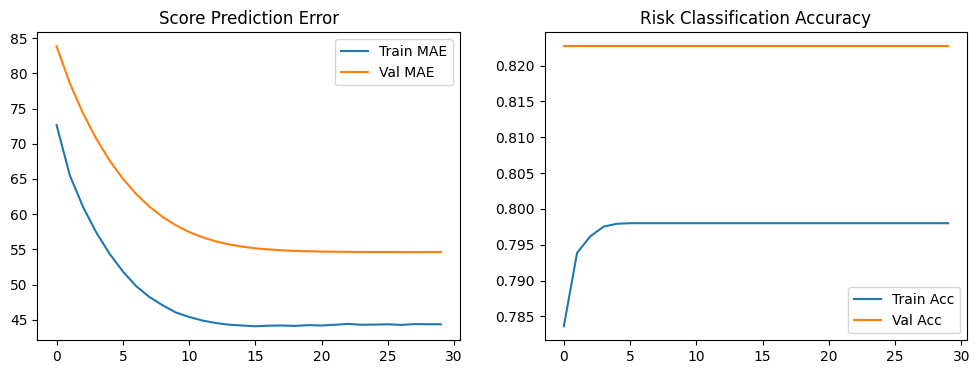

In [49]:
import matplotlib.pyplot as plt

# Plotting the Training History
plt.figure(figsize=(12, 4))

# Subplot 1: Score Error (MAE)
plt.subplot(1, 2, 1)
plt.plot(history.history['score_output_mae'], label='Train MAE')
plt.plot(history.history['val_score_output_mae'], label='Val MAE')
plt.title('Score Prediction Error')
plt.legend()

# Subplot 2: Risk Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['risk_output_accuracy'], label='Train Acc')
plt.plot(history.history['val_risk_output_accuracy'], label='Val Acc')
plt.title('Risk Classification Accuracy')
plt.legend()

plt.show()

The "Heavy Regularization" Model


In [50]:
from tensorflow.keras import layers, models, callbacks

def build_robust_hybrid_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # --- Shared Layers with Increased Regularization ---
    # We add 'dropout' (for inputs) and 'recurrent_dropout' (for internal state)
    # Note: recurrent_dropout=0.2 makes the model much more robust to noise
    x = layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)(inputs)
    x = layers.BatchNormalization()(x) # Helps stabilize the learning

    x = layers.LSTM(32, dropout=0.3)(x)
    x = layers.Dropout(0.4)(x)

    # --- Head 1: Score (Regression) ---
    s = layers.Dense(16, activation='relu')(x)
    s = layers.Dropout(0.3)(s) # Added dropout to the head
    score_output = layers.Dense(1, activation='linear', name='score_output')(s)

    # --- Head 2: Risk (Classification) ---
    r = layers.Dense(16, activation='relu')(x)
    r = layers.Dropout(0.3)(r) # Added dropout to the head
    risk_output = layers.Dense(1, activation='sigmoid', name='risk_output')(r)

    model = models.Model(inputs=inputs, outputs=[score_output, risk_output])
    return model

Stop Training Before it Overfits

In [51]:
# Create the Early Stopping callback
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',     # Watch the validation performance
    patience=7,             # Stop if no improvement for 7 rounds
    restore_best_weights=True # Keep the version of the model that was best
)

# Re-compile and Train
model = build_robust_hybrid_model((X_train.shape[1], X_train.shape[2]))
model.compile(
    optimizer='adam',
    loss={'score_output': 'mse', 'risk_output': 'binary_crossentropy'},
    loss_weights={'score_output': 1.0, 'risk_output': 5.0}
)

history = model.fit(
    X_train,
    {'score_output': y_score, 'risk_output': y_risk},
    epochs=100, # You can set this high now
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop] # Add the callback here
)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 26s 99ms/step - loss: 8952.6748 - risk_output_loss: 0.6610 - score_output_loss: 8949.3379 - val_loss: 7085.2554 - val_risk_output_loss: 0.4994 - val_score_output_loss: 6994.6230
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 3853.1448 - risk_output_loss: 0.5461 - score_output_loss: 3850.4197 - val_loss: 4969.6748 - val_risk_output_loss: 0.4969 - val_score_output_loss: 4968.6055
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 22s 96ms/step - loss: 3341.9590 - risk_output_loss: 0.5141 - score_output_loss: 3339.3921 - val_loss: 4921.0913 - val_risk_output_loss: 0.4971 - val_score_output_loss: 4923.5557
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - loss: 3473.3079 - risk_output_loss: 0.5241 - score_output_loss: 3470.7146 - val_loss: 4944.9331 - val_risk_output_loss: 0.4921 - val_score_output_loss: 4945.6694
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 3354.1343 - risk_output_loss: 0.5223 - score_output_loss: 335

In [52]:
import pandas as pd
print("Class distribution in y_risk:")
print(pd.Series(y_risk).value_counts(normalize=True))

Class distribution in y_risk:
0    0.802937
1    0.197063
Name: proportion, dtype: float64


Calculate the Class Weights

In [53]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Calculate weights: This will give a higher number to Class 1
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_risk),
    y=y_risk
)

# Create a dictionary for the model
# Based on your 80/20 split, this will be roughly {0: 0.62, 1: 2.53}
class_weights = {0: weights[0], 1: weights[1]}

print(f"Calculated Weights: {class_weights}")

Calculated Weights: {0: np.float64(0.6227139577230623), 1: np.float64(2.537258064516129)}


Update the Training Code

In [54]:
import numpy as np

# We use the weights we calculated earlier: {0: 0.62, 1: 2.53}
# This creates an array of the same length as your data
risk_sample_weights = np.array([class_weights[label] for label in y_risk])

# Optional: Since the 'score' output doesn't need class balancing,
# we give it a weight of 1.0 for every sample.
score_sample_weights = np.ones(len(y_score))

In [55]:
history = model.fit(
    X_train,
    [
        y_score, # Changed y to a list, matching the sample_weight structure
        y_risk
    ],
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    # sample_weight is now a list of arrays, matching y
    sample_weight=[
        score_sample_weights,
        risk_sample_weights
    ],
    callbacks=[early_stop]
)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 24s 100ms/step - loss: 3374.0527 - risk_output_loss: 0.7595 - score_output_loss: 3370.2454 - val_loss: 4922.6196 - val_risk_output_loss: 0.6852 - val_score_output_loss: 4924.1118
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - loss: 3250.3269 - risk_output_loss: 0.7044 - score_output_loss: 3246.8022 - val_loss: 4935.1914 - val_risk_output_loss: 0.6851 - val_score_output_loss: 4935.7520
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - loss: 3336.6802 - risk_output_loss: 0.7008 - score_output_loss: 3333.1462 - val_loss: 4890.8276 - val_risk_output_loss: 0.6848 - val_score_output_loss: 4894.7495
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 3297.4626 - risk_output_loss: 0.6910 - score_output_loss: 3294.0298 - val_loss: 4912.3955 - val_risk_output_loss: 0.6853 - val_score_output_loss: 4914.6558
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 23s 102ms/step - loss: 3298.0022 - risk_output_loss: 0.6985 - score_output_loss: 3

In [ ]:
import numpy as np

# We use the weights we calculated earlier: {0: 0.62, 1: 2.53}
# This creates an array of the same length as your data
risk_sample_weights = np.array([class_weights[label] for label in y_risk])
score_sample_weights = np.ones(len(y_score)) # Standard weight for regression

# The Final Fit Command: Pass targets and sample weights as lists
history = model.fit(
    X_train,
    [
        y_score,                # First output target (score_output)
        y_risk                  # Second output target (risk_output)
    ],
    sample_weight=[
        score_sample_weights,   # Corresponding weights for score_output
        risk_sample_weights     # Corresponding weights for risk_output
    ],
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 3286.2620 - risk_output_loss: 0.7055 - score_output_loss: 3282.7358 - val_loss: 4952.2104 - val_risk_output_loss: 0.6848 - val_score_output_loss: 4951.5361
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 94ms/step - loss: 3317.6130 - risk_output_loss: 0.6962 - score_output_loss: 3314.1113 - val_loss: 4901.6943 - val_risk_output_loss: 0.6852 - val_score_output_loss: 4904.7754
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 19s 96ms/step - loss: 3344.7991 - risk_output_loss: 0.7009 - score_output_loss: 3341.2910 - val_loss: 4926.4683 - val_risk_output_loss: 0.6855 - val_score_output_loss: 4927.6704
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - loss: 3338.2175 - risk_output_loss: 0.6984 - score_output_loss: 3334.7139 - val_loss: 4861.6846 - val_risk_output_loss: 0.6852 - val_score_output_loss: 4867.9106
Epoch 5/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 20s 101ms/step - loss: 3189.1594 - risk_output_loss: 0.7053 - score_output_loss: 31